# Chicago Crime Mod5 Project

In [1]:
# Import Nessescary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.utils import resample
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance

In [2]:
# Import the data
crimes_df = pd.read_csv('Crimes_-_2016.csv')
income_df = pd.read_csv('Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv')
police_station_df = pd.read_csv('Police_Stations.csv')

In [3]:
# Joels confusion matrix function
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in predicted and true values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    
    import seaborn as sns
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat, average = 'weighted')
    recall = recall_score(y, y_hat, average = 'weighted')
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat))
    print('Accurancy: ', accuracy)
    sns.heatmap(cm,  cmap= 'Blues', annot=True)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

In [4]:
# Newer updated Conf Matrix Function
def ibbys_cm(y, y_hat, title='Confusion Matrix'):
    # label the axis
    labels = ['Arrest', 'Not Arrest']
    precision = precision_score(y, y_hat, average = 'weighted')
    recall = recall_score(y, y_hat, average = 'weighted')
    accuracy = accuracy_score(y,y_hat)
    cm = np.round(confusion_matrix(y, y_hat)/len(y), 2)
    cm = sns.heatmap(cm, annot = True, cmap='Blues', fmt=".2%");
    plt.xlabel('Actual');
    plt.ylabel('Predicted');
    cm.set_xticklabels(labels);
    cm.set_yticklabels(labels);
    plt.title('Confusion Matrix');
    plt.show()
    print(f'Accuracy score is :{accuracy}')
    print(f'Recall score is :{recall}')

In [5]:
def calc_euclid(row):
    
    chi = [41.8781 , -87.6298]
    crime = [row['Latitude'], row['Longitude']]
    
    return distance.euclidean(crime,chi)

In [6]:
#Check first 5 rows of police stations
police_station_df.head()

,DISTRICT,DISTRICT NAME,ADDRESS,CITY,STATE,ZIP,WEBSITE,PHONE,FAX,TTY,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,1,Central,1718 S State St,Chicago,IL,60616,http://home.chicagopolice.org/community/distri...,312-745-4290,312-745-3694,312-745-3693,1176569.052,1891771.704,41.858373,-87.627356,"(41.8583725929, -87.627356171)"
1,6,Gresham,7808 S Halsted St,Chicago,IL,60620,http://home.chicagopolice.org/community/distri...,312-745-3617,312-745-3649,312-745-3639,1172283.013,1853022.646,41.752137,-87.644229,"(41.7521368378, -87.6442289066)"
2,11,Harrison,3151 W Harrison St,Chicago,IL,60612,http://home.chicagopolice.org/community/distri...,312-746-8386,312-746-4281,312-746-5151,1155244.069,1897148.755,41.873582,-87.705488,"(41.8735822883, -87.705488126)"
3,16,Jefferson Park,5151 N Milwaukee Ave,Chicago,IL,60630,http://home.chicagopolice.org/community/distri...,312-742-4480,312-742-4421,312-742-4423,1138480.758,1933660.473,41.974094,-87.766149,"(41.9740944511, -87.7661488432)"
4,Headquarters,Headquarters,3510 S Michigan Ave,Chicago,IL,60653,http://home.chicagopolice.org,NaN,NaN,NaN,1177731.401,1881697.404,41.830702,-87.623395,"(41.8307016873, -87.6233953459)"


In [7]:
# how many districts are in Chicago
police_station_df["DISTRICT"].nunique()

23

In [8]:
# Check the first 5 rows to see how the data looks
crimes_df.tail()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
269291,24275,HZ293295,06/03/2016 09:01:00 AM,112XX S GREEN ST,0110,HOMICIDE,FIRST DEGREE MURDER,GARAGE,False,False,...,34,75,01A,1172661.0,1830272.0,2016,03/19/2019 04:11:22 PM,41.689698,-87.643512,"(41.689697503, -87.64351179)"
269292,24279,HZ258026,05/10/2016 01:36:00 PM,076XX S EMERALD AVE,0110,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,False,True,...,6,71,01A,1172624.0,1854256.0,2016,03/19/2019 04:11:22 PM,41.755514,-87.642943,"(41.755513816, -87.642943074)"
269293,24280,HZ485035,10/27/2016 12:01:00 AM,082XX S HOUSTON AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,7,46,01A,1197918.0,1850965.0,2016,03/19/2019 04:11:22 PM,41.745889,-87.550358,"(41.745888685, -87.550358227)"
269294,24412,HT476790,04/12/2016 07:00:00 AM,080XX S STEWART AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,17,44,01A,1175022.0,1851634.0,2016,03/19/2019 04:11:22 PM,41.748266,-87.634233,"(41.748265583, -87.634233114)"
269295,24413,HT595485,12/05/2016 07:00:00 AM,025XX E 75TH ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,7,43,01A,1194580.0,1855727.0,2016,03/19/2019 04:11:22 PM,41.759039,-87.562433,"(41.759038683, -87.562432733)"


In [9]:
# Check the total number of rows and columns for crimes data
crimes_df.shape

(269296, 22)

In [10]:
# Check the total number of rows and columns for income data
income_df.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [11]:
# Check the data types of each column in crimes data
crimes_df.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                  int64
Ward                      int64
Community Area            int64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [12]:
#drop nas in crimes df
crimes_df.dropna(inplace=True)

In [13]:
# Check the data types of each column in income data
income_df.dtypes

Community Area Number                           float64
COMMUNITY AREA NAME                              object
PERCENT OF HOUSING CROWDED                      float64
PERCENT HOUSEHOLDS BELOW POVERTY                float64
PERCENT AGED 16+ UNEMPLOYED                     float64
PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA    float64
PERCENT AGED UNDER 18 OR OVER 64                float64
PER CAPITA INCOME                                 int64
HARDSHIP INDEX                                  float64
dtype: object

In [14]:
# Join the 2 dataframes together 
df = crimes_df.join(income_df, on = 'Community Area', how='right' )
# The on paramater is the similair column in both dataframes so we will join on that column.
#the how parameter lets us join on the crimes_df index which is what we want.
police_station_df.columns

Index(['DISTRICT', 'DISTRICT NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP',
       'WEBSITE', 'PHONE', 'FAX', 'TTY', 'X COORDINATE', 'Y COORDINATE',
       'LATITUDE', 'LONGITUDE', 'LOCATION'],
      dtype='object')

In [15]:
# Drop columns I dont need
police_station_df.drop(['DISTRICT NAME', 'ADDRESS', 'CITY', 'STATE','WEBSITE', 'PHONE', 'FAX', 'TTY', 'X COORDINATE', 'Y COORDINATE'],axis=1, inplace=True)

In [16]:
# Chnage the name of the columns so there is no confusion when merging
police_station_df['PS_LATITUDE']= police_station_df['LATITUDE']
police_station_df['PS_LONGITUDE']=police_station_df['LONGITUDE']
police_station_df['PS_LOCATION']=police_station_df['LOCATION']
# Join the police stations df with the new merged df
pdf = df.join(police_station_df, on= 'District', how='right')


In [17]:
#pdf['Euc_Dist'] = pdf.apply(calc_euclid,axis=1)

In [18]:
pdf.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,PER CAPITA INCOME,HARDSHIP INDEX,DISTRICT,ZIP,LATITUDE,LONGITUDE,LOCATION,PS_LATITUDE,PS_LONGITUDE,PS_LOCATION
0,10380921.0,HZ116684,01/15/2016 02:05:00 PM,043XX N CENTRAL PARK AVE,0320,ROBBERY,STRONGARM - NO WEAPON,SIDEWALK,False,False,...,26282.0,28.0,12,60608,41.862977,-87.656973,"(41.8629766244, -87.6569725149)",41.862977,-87.656973,"(41.8629766244, -87.6569725149)"
2275,10403022.0,HZ139394,02/03/2016 07:00:00 PM,043XX N ELSTON AVE,0560,ASSAULT,SIMPLE,ALLEY,False,False,...,26282.0,28.0,12,60608,41.862977,-87.656973,"(41.8629766244, -87.6569725149)",41.862977,-87.656973,"(41.8629766244, -87.6569725149)"
2286,10410674.0,HZ147546,02/11/2016 12:10:00 AM,037XX N KIMBALL AVE,0560,ASSAULT,SIMPLE,SIDEWALK,True,False,...,26282.0,28.0,12,60608,41.862977,-87.656973,"(41.8629766244, -87.6569725149)",41.862977,-87.656973,"(41.8629766244, -87.6569725149)"
2301,10426906.0,HZ164391,02/25/2016 10:00:00 AM,037XX N ELSTON AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,...,26282.0,28.0,12,60608,41.862977,-87.656973,"(41.8629766244, -87.6569725149)",41.862977,-87.656973,"(41.8629766244, -87.6569725149)"
2546,10644764.0,HZ395793,08/16/2016 05:30:00 PM,042XX W ROSCOE ST,0460,BATTERY,SIMPLE,ALLEY,False,False,...,26282.0,28.0,12,60608,41.862977,-87.656973,"(41.8629766244, -87.6569725149)",41.862977,-87.656973,"(41.8629766244, -87.6569725149)"


In [19]:
# Check the shape
df.shape

(266454, 31)

In [20]:
#Change columns names so theyre more specific
pdf['Latitude'].rename('Arr_Latitude')
pdf['Longitude'].rename('Arr_Longitude')

0        -87.718000
2275     -87.728585
2286     -87.712781
2301     -87.712274
2546     -87.733798
2661     -87.729650
2854     -87.735748
2894     -87.726997
2942     -87.707935
2959     -87.714086
2992     -87.734607
3574     -87.716713
3576     -87.709519
3856     -87.740605
3896     -87.722191
3922     -87.710659
4159     -87.703097
4207     -87.711747
4435     -87.734744
4458     -87.705880
4586     -87.720395
4594     -87.715236
4772     -87.732601
4887     -87.736084
4974     -87.736084
5096     -87.721458
5112     -87.742741
5148     -87.720450
5208     -87.722228
5332     -87.722191
            ...    
266116   -87.627133
266452   -87.612881
266662   -87.625775
266674   -87.627280
266709   -87.614818
266725   -87.625814
266848   -87.618996
266877   -87.627214
266991   -87.626155
267168   -87.623951
267254   -87.624051
267319   -87.627022
267386   -87.620711
267391   -87.624061
267453   -87.627164
267759   -87.623948
267888   -87.621728
268037   -87.623836
268109   -87.620788


In [21]:
pdf.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Community Area Number', 'COMMUNITY AREA NAME',
       'PERCENT OF HOUSING CROWDED', 'PERCENT HOUSEHOLDS BELOW POVERTY',
       'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'DISTRICT', 'ZIP', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'PS_LATITUDE', 'PS_LONGITUDE', 'PS_LOCATION'],
      dtype='object')

In [22]:
# Check the total number of Nans in the dataframe
df.isna().sum()

ID                                                 1
Case Number                                        1
Date                                               1
Block                                              1
IUCR                                               1
Primary Type                                       1
Description                                        1
Location Description                               1
Arrest                                             1
Domestic                                           1
Beat                                               1
District                                           1
Ward                                               1
Community Area                                     0
FBI Code                                           1
X Coordinate                                       1
Y Coordinate                                       1
Year                                               1
Updated On                                    

In [23]:
# Drop the Nans. Use the parameter inplace and set it to True, so the Na stay dropped.
df.dropna(inplace=True)

In [24]:
# Check the total number of Nan again. Good they are all dropped!
df.isna().sum()

ID                                              0
Case Number                                     0
Date                                            0
Block                                           0
IUCR                                            0
Primary Type                                    0
Description                                     0
Location Description                            0
Arrest                                          0
Domestic                                        0
Beat                                            0
District                                        0
Ward                                            0
Community Area                                  0
FBI Code                                        0
X Coordinate                                    0
Y Coordinate                                    0
Year                                            0
Updated On                                      0
Latitude                                        0


In [25]:
# Check the shape. We lost a little data, but we have more than enough to work with.
df.shape

(264118, 31)

In [26]:
# Check for duplicates. There are 0 duplicates in the data.
df.duplicated().sum()

0

In [27]:
# check the head of our new joined data frame
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Location,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,10380921.0,HZ116684,01/15/2016 02:05:00 PM,043XX N CENTRAL PARK AVE,0320,ROBBERY,STRONGARM - NO WEAPON,SIDEWALK,False,False,...,"(41.959835996, -87.717999724)",17.0,Dunning,5.2,10.6,10.0,16.2,33.6,26282,28.0
2275,10403022.0,HZ139394,02/03/2016 07:00:00 PM,043XX N ELSTON AVE,0560,ASSAULT,SIMPLE,ALLEY,False,False,...,"(41.960161177, -87.728585458)",17.0,Dunning,5.2,10.6,10.0,16.2,33.6,26282,28.0
2286,10410674.0,HZ147546,02/11/2016 12:10:00 AM,037XX N KIMBALL AVE,0560,ASSAULT,SIMPLE,SIDEWALK,True,False,...,"(41.94896278, -87.712781393)",17.0,Dunning,5.2,10.6,10.0,16.2,33.6,26282,28.0
2301,10426906.0,HZ164391,02/25/2016 10:00:00 AM,037XX N ELSTON AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,...,"(41.948973757, -87.712273992)",17.0,Dunning,5.2,10.6,10.0,16.2,33.6,26282,28.0
2546,10644764.0,HZ395793,08/16/2016 05:30:00 PM,042XX W ROSCOE ST,0460,BATTERY,SIMPLE,ALLEY,False,False,...,"(41.942647489, -87.733797696)",17.0,Dunning,5.2,10.6,10.0,16.2,33.6,26282,28.0


In [28]:
# Check the total columns and drop unneeded columns.
df.columns
# put the columns you want to drop as a list, then set the axis = to 1 because you are dropping by column.
df.drop(['Case Number','Description','FBI Code','PERCENT OF HOUSING CROWDED','Community Area Number'],axis = 1, inplace=True)

In [29]:
# check the data again
df.shape

(264118, 26)

In [30]:
# What features can I use to identify whether an arrest has been made or not?
# What features can I use to identify the primary type. Can we figure out what crime it is based on the features?
# Can I figure out a reaction time by any chance. Try to find out the time when the arrest was made(no reaction time)
# Crime per capita income and per hardship index and unemployment
# is there an inbalance in my data (yes)
# what features do I need to scale 

In [31]:
#Check the columns types
df.dtypes

ID                                              float64
Date                                             object
Block                                            object
IUCR                                             object
Primary Type                                     object
Location Description                             object
Arrest                                           object
Domestic                                         object
Beat                                            float64
District                                        float64
Ward                                            float64
Community Area                                    int64
X Coordinate                                    float64
Y Coordinate                                    float64
Year                                            float64
Updated On                                       object
Latitude                                        float64
Longitude                                       

In [32]:
# see if there is an inbalance in the data 
df['Arrest'].value_counts()

#There is an inbalance so I will probably have to stratify

False    211697
True      52421
Name: Arrest, dtype: int64

In [33]:
# Get rid of [ID, Location Description, 'X Coordinate', 'Y Coordinate']
df.columns

Index(['ID', 'Date', 'Block', 'IUCR', 'Primary Type', 'Location Description',
       'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area',
       'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude',
       'Longitude', 'Location', 'COMMUNITY AREA NAME',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX'],
      dtype='object')

In [34]:
df.drop(['ID', 'Location Description', 'X Coordinate', 'Y Coordinate'],axis=1,inplace=True)

In [35]:
df.shape

(264118, 22)

In [36]:
df.columns

Index(['Date', 'Block', 'IUCR', 'Primary Type', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'Year', 'Updated On', 'Latitude',
       'Longitude', 'Location', 'COMMUNITY AREA NAME',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX'],
      dtype='object')

In [37]:
df.head()

,Date,Block,IUCR,Primary Type,Arrest,Domestic,Beat,District,Ward,Community Area,...,Latitude,Longitude,Location,COMMUNITY AREA NAME,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,01/15/2016 02:05:00 PM,043XX N CENTRAL PARK AVE,0320,ROBBERY,False,False,1723.0,17.0,35.0,16,...,41.959836,-87.718000,"(41.959835996, -87.717999724)",Dunning,10.6,10.0,16.2,33.6,26282,28.0
2275,02/03/2016 07:00:00 PM,043XX N ELSTON AVE,0560,ASSAULT,False,False,1722.0,17.0,39.0,16,...,41.960161,-87.728585,"(41.960161177, -87.728585458)",Dunning,10.6,10.0,16.2,33.6,26282,28.0
2286,02/11/2016 12:10:00 AM,037XX N KIMBALL AVE,0560,ASSAULT,True,False,1732.0,17.0,35.0,16,...,41.948963,-87.712781,"(41.94896278, -87.712781393)",Dunning,10.6,10.0,16.2,33.6,26282,28.0
2301,02/25/2016 10:00:00 AM,037XX N ELSTON AVE,0560,ASSAULT,False,False,1733.0,17.0,35.0,16,...,41.948974,-87.712274,"(41.948973757, -87.712273992)",Dunning,10.6,10.0,16.2,33.6,26282,28.0
2546,08/16/2016 05:30:00 PM,042XX W ROSCOE ST,0460,BATTERY,False,False,1731.0,17.0,30.0,16,...,41.942647,-87.733798,"(41.942647489, -87.733797696)",Dunning,10.6,10.0,16.2,33.6,26282,28.0


In [38]:
#Chnge the true and false columns to 0s and 1s
df['Arrest'] = [1 if i ==True else 0 for i in df.Arrest]
df['Domestic'] =[1 if i ==True else 0 for i in df.Domestic]

In [39]:
# Check for the inbalance
df['Arrest'].value_counts()

0    211697
1     52421
Name: Arrest, dtype: int64

In [40]:
# drop the year column
#df.drop('Year',axis=1,inplace=True)
df['Euc_Dist'] = df.apply(calc_euclid,axis=1)


In [41]:
df.head()

,Date,Block,IUCR,Primary Type,Arrest,Domestic,Beat,District,Ward,Community Area,...,Longitude,Location,COMMUNITY AREA NAME,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Euc_Dist
0,01/15/2016 02:05:00 PM,043XX N CENTRAL PARK AVE,0320,ROBBERY,0,0,1723.0,17.0,35.0,16,...,-87.718000,"(41.959835996, -87.717999724)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.120250
2275,02/03/2016 07:00:00 PM,043XX N ELSTON AVE,0560,ASSAULT,0,0,1722.0,17.0,39.0,16,...,-87.728585,"(41.960161177, -87.728585458)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.128424
2286,02/11/2016 12:10:00 AM,037XX N KIMBALL AVE,0560,ASSAULT,1,0,1732.0,17.0,35.0,16,...,-87.712781,"(41.94896278, -87.712781393)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.109121
2301,02/25/2016 10:00:00 AM,037XX N ELSTON AVE,0560,ASSAULT,0,0,1733.0,17.0,35.0,16,...,-87.712274,"(41.948973757, -87.712273992)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.108743
2546,08/16/2016 05:30:00 PM,042XX W ROSCOE ST,0460,BATTERY,0,0,1731.0,17.0,30.0,16,...,-87.733798,"(41.942647489, -87.733797696)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.122401


In [42]:
pdf.isna().sum()

ID                                                 3
Case Number                                        3
Date                                               3
Block                                              3
IUCR                                               3
Primary Type                                       3
Description                                        3
Location Description                               3
Arrest                                             3
Domestic                                           3
Beat                                               3
District                                           0
Ward                                               3
Community Area                                     3
FBI Code                                           3
X Coordinate                                       3
Y Coordinate                                       3
Year                                               3
Updated On                                    

In [43]:
pdf.dropna(inplace=True)

In [44]:
pdf['Euc_Dist'] = pdf.apply(calc_euclid,axis=1)

In [45]:
pdf.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,HARDSHIP INDEX,DISTRICT,ZIP,LATITUDE,LONGITUDE,LOCATION,PS_LATITUDE,PS_LONGITUDE,PS_LOCATION,Euc_Dist
0,10380921.0,HZ116684,01/15/2016 02:05:00 PM,043XX N CENTRAL PARK AVE,0320,ROBBERY,STRONGARM - NO WEAPON,SIDEWALK,False,False,...,28.0,12,60608,41.862977,-87.656973,"(41.8629766244, -87.6569725149)",41.862977,-87.656973,"(41.8629766244, -87.6569725149)",0.120250
2275,10403022.0,HZ139394,02/03/2016 07:00:00 PM,043XX N ELSTON AVE,0560,ASSAULT,SIMPLE,ALLEY,False,False,...,28.0,12,60608,41.862977,-87.656973,"(41.8629766244, -87.6569725149)",41.862977,-87.656973,"(41.8629766244, -87.6569725149)",0.128424
2286,10410674.0,HZ147546,02/11/2016 12:10:00 AM,037XX N KIMBALL AVE,0560,ASSAULT,SIMPLE,SIDEWALK,True,False,...,28.0,12,60608,41.862977,-87.656973,"(41.8629766244, -87.6569725149)",41.862977,-87.656973,"(41.8629766244, -87.6569725149)",0.109121
2301,10426906.0,HZ164391,02/25/2016 10:00:00 AM,037XX N ELSTON AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,...,28.0,12,60608,41.862977,-87.656973,"(41.8629766244, -87.6569725149)",41.862977,-87.656973,"(41.8629766244, -87.6569725149)",0.108743
2546,10644764.0,HZ395793,08/16/2016 05:30:00 PM,042XX W ROSCOE ST,0460,BATTERY,SIMPLE,ALLEY,False,False,...,28.0,12,60608,41.862977,-87.656973,"(41.8629766244, -87.6569725149)",41.862977,-87.656973,"(41.8629766244, -87.6569725149)",0.122401


# Vanilla Models

In [46]:
# Define the target variable
y = df['Arrest']

# Define the features
X = df.drop(['Arrest', 'Date','Block', 'Primary Type','Updated On','COMMUNITY AREA NAME','IUCR','Location'],axis=1)

In [47]:
# Run a train test split with a .2 test size
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=5, stratify = y)

# Validation Set

In [48]:
# make a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .2, random_state=5)

In [49]:
X.columns

Index(['Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'Year',
       'Latitude', 'Longitude', 'PERCENT HOUSEHOLDS BELOW POVERTY',
       'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'Euc_Dist'],
      dtype='object')

# Logistic Regression
### vanilla

In [50]:
# instantiate the model

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model to the training data

logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
# Make predictions using this model
log_train_preds = logreg.predict(X_train)
log_test_preds = logreg.predict(X_test)

In [52]:
# Get training and test accuracy and other metrics
log_train_acc = accuracy_score(y_train, log_train_preds)
log_test_acc = accuracy_score(y_test, log_test_preds)
log_test_pre = precision_score(y_test, log_test_preds)
log_test_rec = recall_score(y_test, log_test_preds)
log_test_f1 = f1_score(y_test, log_test_preds)


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
#print all the metrics for the messy model
print(f'The accuracy for the training data is {log_train_acc}')
print(f'The accuracy for the testing data is {log_test_acc}')
print(f'The recall score for the testing data is {log_test_rec}')
print(f'The precision score for the testing data is {log_test_pre}')
print(f'The f1 score for the testing data is {log_test_f1}')

The accuracy for the training data is 0.8015795545301269
The accuracy for the testing data is 0.8015296077540512
The recall score for the testing data is 0.0
The precision score for the testing data is 0.0
The f1 score for the testing data is 0.0


In [54]:
print(f'The cross val score is {np.mean(cross_val_score(logreg, X,y, cv=3))}')

The cross val score is 0.801524318710323


# Random Forest
### vanilla

In [55]:
# make a random forest class

clf = RandomForestClassifier(criterion = 'entropy',
                            max_depth = 5,
                            n_estimators=20)


# Fit the model to the training data
clf.fit(X_train, y_train)

# use the model to predict test accuracy

y_hat_test = clf.predict(X_test)
rf_acc = accuracy_score(y_test, y_hat_test)
rf_prec = precision_score(y_test, y_hat_test)
rf_rec = recall_score(y_test, y_hat_test)

print(f'The accuarcy  score is {rf_acc}')
print(f'The precision score is {rf_prec}')
print(f'The recall score is {rf_rec}')


The accuarcy  score is 0.8019460851128275
The precision score is 1.0
The recall score is 0.002098435711560473


In [56]:
print(f'The cross val score is {np.mean(cross_val_score(clf, X,y, cv=3))}')

The cross val score is 0.7821089014757326


# XGBoost
### Vanilla

In [57]:
#Run an XGboost model

#Instantiate XGB

xgb = XGBClassifier()

#Fit xgb to training data
xgb.fit(X_train, y_train)

# predict on training and test data

train_preds = xgb.predict(X_train)
test_preds = xgb.predict(X_test)

In [58]:
# Test the training and test data accuracy of the predictions
xgb_train_acc =accuracy_score(y_train, train_preds)
xgb_test_acc = accuracy_score(y_test, test_preds)

#Get precision and recall score
xgb_test_rec = recall_score(y_test, test_preds)
xgb_test_prec = precision_score(y_test, test_preds)

#print both train and test accuracy
print(f'The accuracy for the training data is {xgb_train_acc}')
print(f'The accuracy for the testing data is {xgb_test_acc}')
print(f'The recall score for the testing data is {xgb_test_rec}')
print(f'The precision score for the testing data is {xgb_test_prec}')

The accuracy for the training data is 0.8041234063951253
The accuracy for the testing data is 0.8034416174466151
The recall score for the testing data is 0.02260587561999237
The precision score for the testing data is 0.6353887399463807


In [59]:
print(f'The cross val score is {np.mean(cross_val_score(xgb, X,y, cv=3))}')

The cross val score is 0.7479880460283529


# AdaBoost
### Vanilla

In [60]:
# Instantiate ada boost classifier
adab = AdaBoostClassifier(random_state=1)

In [61]:
# Fit ada boost to Training data
adab.fit(X_train,y_train)
# get train and test predictions
adab_train_preds = adab.predict(X_train)
adab_test_preds = adab.predict(X_test)

In [62]:
# get train and test accuracy scores
adab_train_acc = accuracy_score(y_train, adab_train_preds)
adab_test_acc = accuracy_score(y_test, adab_test_preds)

# get all the other metrics for the test data
adab_test_rec = recall_score(y_test, adab_test_preds)
adab_test_pre = precision_score(y_test, adab_test_preds)
adab_test_f1 = f1_score(y_test, adab_test_preds)

#print test metrics
print(f'The accuracy for the training data is {adab_train_acc}')
print(f'The accuracy for the testing data is {adab_test_acc}')
print(f'The recall score for the testing data is {adab_test_rec}')
print(f'The precision score for the testing data is {adab_test_pre}')
print(f'The F1 score for the testing data is {adab_test_f1}')

The accuracy for the training data is 0.8019463424734522
The accuracy for the testing data is 0.8019082235347569
The recall score for the testing data is 0.0019076688286913392
The precision score for the testing data is 1.0
The F1 score for the testing data is 0.003808073115003808


In [63]:
print(f'The cross val score is {np.mean(cross_val_score(adab, X,y, cv=3))}')

The cross val score is 0.7812570156250972


# GradientBoosting
### Vanilla

In [64]:
# Instantiate Gradient Boosting
gbb = GradientBoostingClassifier(random_state=1)

In [65]:
# Fit the training data 
gbb.fit(X_train, y_train)

# make predictions on train and test data
gbb_train_preds = gbb.predict(X_train)
gbb_test_preds = gbb.predict(X_test)

# get training and testing accuracy
gbb_train_acc = accuracy_score(y_train,gbb_train_preds)
gbb_test_acc = accuracy_score(y_test, gbb_test_preds)



In [66]:
# Get all the other metrics 
gbb_test_rec = recall_score(y_test, gbb_test_preds)
gbb_test_pre = precision_score(y_test, gbb_test_preds)
gbb_test_f1 = f1_score(y_test, gbb_test_preds)

# Print them
print(f'The accuracy for the training data is {gbb_train_acc}')
print(f'The accuracy for the testing data is {gbb_test_acc}')
print(f'The recall score for the testing data is {gbb_test_rec}')
print(f'The precision score for the testing data is {gbb_test_pre}')
print(f'The F1 score for the testing data is {gbb_test_f1}')


The accuracy for the training data is 0.8045848492915668
The accuracy for the testing data is 0.8045963955777676
The recall score for the testing data is 0.024036627241510875
The precision score for the testing data is 0.7368421052631579
The F1 score for the testing data is 0.046554590799926104


In [67]:
print(f'The cross val score is {np.mean(cross_val_score(gbb, X,y, cv=3))}')

The cross val score is 0.7521755378531368


In [68]:
#ibbys_cm(y_test, gbb_test_preds)

In [69]:
df.head()

,Date,Block,IUCR,Primary Type,Arrest,Domestic,Beat,District,Ward,Community Area,...,Longitude,Location,COMMUNITY AREA NAME,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Euc_Dist
0,01/15/2016 02:05:00 PM,043XX N CENTRAL PARK AVE,0320,ROBBERY,0,0,1723.0,17.0,35.0,16,...,-87.718000,"(41.959835996, -87.717999724)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.120250
2275,02/03/2016 07:00:00 PM,043XX N ELSTON AVE,0560,ASSAULT,0,0,1722.0,17.0,39.0,16,...,-87.728585,"(41.960161177, -87.728585458)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.128424
2286,02/11/2016 12:10:00 AM,037XX N KIMBALL AVE,0560,ASSAULT,1,0,1732.0,17.0,35.0,16,...,-87.712781,"(41.94896278, -87.712781393)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.109121
2301,02/25/2016 10:00:00 AM,037XX N ELSTON AVE,0560,ASSAULT,0,0,1733.0,17.0,35.0,16,...,-87.712274,"(41.948973757, -87.712273992)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.108743
2546,08/16/2016 05:30:00 PM,042XX W ROSCOE ST,0460,BATTERY,0,0,1731.0,17.0,30.0,16,...,-87.733798,"(41.942647489, -87.733797696)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.122401


# Real Models With UpSampling

In [70]:
y_train.head()

82478     0
33021     0
115586    1
247802    0
148426    0
Name: Arrest, dtype: int64

In [71]:
train_df = pd.merge(X_train, y_train, left_index = True, right_index=True )

In [72]:
# Fix the class imbalance with upsampling:
# First seperate the target variable by majority and minority
df_arr_maj = train_df[train_df.Arrest == 0]
df_arr_min = train_df[train_df.Arrest == 1]

# Upsample the minority class

df_min_upsample = resample(df_arr_min,
                          replace = True,
                          n_samples = 211697,
                          random_state=101)

# Combine the min_upsample with the majority

train_df = pd.concat([df_arr_maj,df_min_upsample])

In [73]:
# Check if the data is now balanced. Now it is.
train_df['Arrest'].value_counts()

## if upsampling does not give me good results then I can down sample 

1    211697
0    135495
Name: Arrest, dtype: int64

In [74]:
# Define the target variable
y_train1 = train_df['Arrest']

# Define the features
X_train1 = train_df.drop(['Arrest'],axis=1)

In [75]:
# Run a train test split with a .2 test size
#X_train1, X_test, y_train1, y_test = train_test_split(X_train1,y_train1, test_size=.2, random_state=5, stratify= y_train1)

# Random Forest Upsampling

In [76]:
new_clf = RandomForestClassifier(criterion = 'entropy',
                            max_depth = 10,
                            n_estimators=50)


# Fit the model to the training data
new_clf.fit(X_train1, y_train1)

# use the model to predict test accuracy

y_hat_test1 = new_clf.predict(X_test)
rf_acc1 = accuracy_score(y_test, y_hat_test1)
rf_prec1 = precision_score(y_test, y_hat_test1)
rf_rec1 = recall_score(y_test, y_hat_test1)
rf_f1_1 = f1_score(y_test, y_hat_test)
print(f'The accuarcy  score is {rf_acc1}')
print(f'The precision score is {rf_prec1}')
print(f'The recall score is {rf_rec1}')
print(f'The F1 score for the testing data is {rf_f1_1*100}%')

The accuarcy  score is 0.3908829320006058
The precision score is 0.23044040163038076
The recall score is 0.8843952689813048
The F1 score for the testing data is 0.41880830001903663%


In [77]:
#(f'The cross val score is {np.mean(cross_val_score(new_clf, X_train1,y_train1, cv=3))}')

# XGBoost Model With UpSample

In [78]:
#Run an XGboost model

#Instantiate XGB

xgb1 = XGBClassifier()

#Fit xgb to training data
xgb1.fit(X_train1, y_train1)

# predict on training and test data

train_preds1 = xgb.predict(X_train1)
test_preds1 = xgb.predict(X_test)

In [79]:
# Test the training and test data accuracy of the predictions
xgb_train_acc1 =accuracy_score(y_train1, train_preds1)
xgb_test_acc1 = accuracy_score(y_test, test_preds1)

#Get precision and recall score
xgb_test_rec1 = recall_score(y_test, test_preds1)
xgb_test_prec1 = precision_score(y_test, test_preds1)
xgb_test_f1_1 = f1_score(y_test, test_preds1)
#print both train and test accuracy
print(f'The accuracy for the training data is {xgb_train_acc1}')
print(f'The accuracy for the testing data is {xgb_test_acc1}')
print(f'The recall score for the testing data is {xgb_test_rec1}')
print(f'The precision score for the testing data is {xgb_test_prec1}')
print(f'The F1 score for the testing data is {xgb_test_f1_1*100}%')

The accuracy for the training data is 0.4037477822069633
The accuracy for the testing data is 0.8034416174466151
The recall score for the testing data is 0.02260587561999237
The precision score for the testing data is 0.6353887399463807
The F1 score for the testing data is 4.365846919038409%


In [80]:
#print(f'The cross val score is {np.mean(cross_val_score(xgb1, X_train1,y_train1, cv=3))}')

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     42340
           1       0.64      0.02      0.04     10484

    accuracy                           0.80     52824
   macro avg       0.72      0.51      0.47     52824
weighted avg       0.77      0.80      0.72     52824

Accurancy:  0.8034416174466151


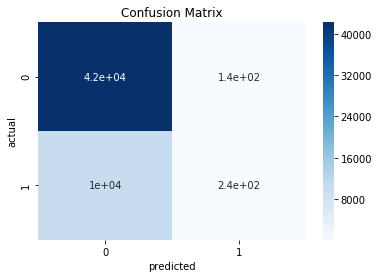

In [81]:
evaluation(y_test, test_preds1)

# AdaBoosting With Upsampling

In [82]:
# Instantiate ada boost classifier
adab1 = AdaBoostClassifier(random_state=1)

# Fit ada boost to Training data
adab1.fit(X_train1,y_train1)

# get train and test predictions
adab_train_preds1 = adab1.predict(X_train1)
adab_test_preds1 = adab1.predict(X_test)


In [83]:
# get train and test accuracy scores
adab_train_acc1 = accuracy_score(y_train1, adab_train_preds1)
adab_test_acc1 = accuracy_score(y_test, adab_test_preds1)

# get all the other metrics for the test data
adab_test_rec1 = recall_score(y_test, adab_test_preds1)
adab_test_pre1 = precision_score(y_test, adab_test_preds1)
adab_test_f1_1 = f1_score(y_test, adab_test_preds1)

#print test metrics
print(f'The accuracy for the training data is {adab_train_acc1}')
print(f'The accuracy for the testing data is {adab_test_acc1}')
print(f'The recall score for the testing data is {adab_test_rec1}')
print(f'The precision score for the testing data is {adab_test_pre1}')
print(f'The F1 score for the testing data is {adab_test_f1_1}')

The accuracy for the training data is 0.61789442153045
The accuracy for the testing data is 0.30410419506285025
The recall score for the testing data is 0.9218809614650897
The precision score for the testing data is 0.21192386966627197
The F1 score for the testing data is 0.3446247102870387


In [84]:
#print(f'the cross val score is {np.mean(cross_val_score(adab1, X_train1,y_train1, cv=3))}')

# ^ Make a confusion matrix

# Gradient Boosting UpSampling

In [85]:
# Instantiate Gradient Boosting
gbb1 = GradientBoostingClassifier(random_state=1)

# Fit the training data 
gbb1.fit(X_train1, y_train1)

# make predictions on train and test data
gbb_train_preds1 = gbb1.predict(X_train1)
gbb_test_preds1 = gbb1.predict(X_test)

# get training and testing accuracy
gbb_train_acc1 = accuracy_score(y_train1,gbb_train_preds1)
gbb_test_acc1 = accuracy_score(y_test, gbb_test_preds1)




In [86]:
# Get all the other metrics 
gbb_test_rec1 = recall_score(y_test, gbb_test_preds1)
gbb_test_pre1 = precision_score(y_test, gbb_test_preds1)
gbb_test_f1_1 = f1_score(y_test, gbb_test_preds1)

# Print them
print(f'The accuracy for the training data is {gbb_train_acc1}')
print(f'The accuracy for the testing data is {gbb_test_acc1}')
print(f'The recall score for the testing data is {gbb_test_rec1}')
print(f'The precision score for the testing data is {gbb_test_pre1}')
print(f'The F1 score for the testing data is {gbb_test_f1_1}')


The accuracy for the training data is 0.6338135671328833
The accuracy for the testing data is 0.3305505073451461
The recall score for the testing data is 0.9124380007630676
The precision score for the testing data is 0.21735475222103565
The F1 score for the testing data is 0.35107808055784934


In [87]:
print(f'The cross val score is {np.mean(cross_val_score(gbb1, X_train1,y_train1, cv=3))}')

The cross val score is 0.6329293243474041


# Logistic Reg With Upsampling


In [88]:
# instantiate the model

logreg1 = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model to the training data

logreg1.fit(X_train1, y_train1)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
# Make predictions using this model
log_train_preds1 = logreg1.predict(X_train1)
log_test_preds1 = logreg1.predict(X_test)

In [90]:
# Get training and test accuracy and other metrics
log_train_acc1 = accuracy_score(y_train1, train_preds1)
log_test_acc1 = accuracy_score(y_test, test_preds1)
log_test_pre1 = precision_score(y_test, test_preds1)
log_test_rec1 = recall_score(y_test, test_preds1)
log_test_f1_1 = f1_score(y_test, test_preds1)


In [91]:
#print all the metrics for the messy model
print(f'The accuracy for the training data is {log_train_acc1*100}%')
print(f'The accuracy for the testing data is {log_test_acc1*100}%')
print(f'The recall score for the testing data is {log_test_rec1*100}%')
print(f'The precision score for the testing data is {log_test_pre1*100}%')
print(f'The f1 score for the testing data is {log_test_f1_1*100}%')

The accuracy for the training data is 40.37477822069633%
The accuracy for the testing data is 80.34416174466152%
The recall score for the testing data is 2.260587561999237%
The precision score for the testing data is 63.53887399463807%
The f1 score for the testing data is 4.365846919038409%


In [92]:
# do a cross validation
print(f'the cross val score is {np.mean(cross_val_score(logreg1, X_train1,y_train1, cv=3))}')

the cross val score is 0.6121569613474424


In [93]:

# distance from the police station 
# may deal with mulycollinearity 
# Do something with the distances from where the crime took place to the nearest ward

In [94]:
# cross val, logistic reg on all metrics, features engineering on X_train1 and y_train1 data 

In [95]:
X_train1.columns

Index(['Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'Year',
       'Latitude', 'Longitude', 'PERCENT HOUSEHOLDS BELOW POVERTY',
       'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'Euc_Dist'],
      dtype='object')

In [96]:
# Nearest Police stations data added to dataset

In [97]:
# Check what columns I have and which I should drop
pdf.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Community Area Number', 'COMMUNITY AREA NAME',
       'PERCENT OF HOUSING CROWDED', 'PERCENT HOUSEHOLDS BELOW POVERTY',
       'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'DISTRICT', 'ZIP', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'PS_LATITUDE', 'PS_LONGITUDE', 'PS_LOCATION', 'Euc_Dist'],
      dtype='object')

In [98]:
# Drop unneeded columns
pdf = pdf.drop(['ID', 'X Coordinate', 'Y Coordinate','Primary Type',
       'Description', 'Location Description','COMMUNITY AREA NAME','Updated On',],axis=1)

In [99]:
pdf = pdf.drop(['Case Number', 'Date', 'Block','Location','PS_LOCATION'],axis=1)

In [100]:
pdf = pdf.drop(['LOCATION','IUCR'], axis=1)

In [101]:
pdf = pdf.drop("DISTRICT",axis=1)

In [102]:
pdf = pdf.drop('FBI Code',axis=1)

In [103]:
pdf = pdf.drop(['Year', 'Community Area Number'],axis=1)

In [104]:
pdf.columns

Index(['Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area',
       'Latitude', 'Longitude', 'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'ZIP', 'LATITUDE', 'LONGITUDE', 'PS_LATITUDE',
       'PS_LONGITUDE', 'Euc_Dist'],
      dtype='object')

In [105]:
#Chnge the true and false columns to 0s and 1s
pdf['Arrest'] = [1 if i ==True else 0 for i in pdf.Arrest]
pdf['Domestic'] =[1 if i ==True else 0 for i in pdf.Domestic]

In [106]:
# Drop NA values
pdf.dropna(inplace=True)

In [107]:
# check to see if they all dropped
pdf.isna().sum()

Arrest                                          0
Domestic                                        0
Beat                                            0
District                                        0
Ward                                            0
Community Area                                  0
Latitude                                        0
Longitude                                       0
PERCENT OF HOUSING CROWDED                      0
PERCENT HOUSEHOLDS BELOW POVERTY                0
PERCENT AGED 16+ UNEMPLOYED                     0
PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA    0
PERCENT AGED UNDER 18 OR OVER 64                0
PER CAPITA INCOME                               0
HARDSHIP INDEX                                  0
ZIP                                             0
LATITUDE                                        0
LONGITUDE                                       0
PS_LATITUDE                                     0
PS_LONGITUDE                                    0


In [108]:
# check the data types of all the columns
pdf.dtypes

Arrest                                            int64
Domestic                                          int64
Beat                                            float64
District                                        float64
Ward                                            float64
Community Area                                  float64
Latitude                                        float64
Longitude                                       float64
PERCENT OF HOUSING CROWDED                      float64
PERCENT HOUSEHOLDS BELOW POVERTY                float64
PERCENT AGED 16+ UNEMPLOYED                     float64
PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA    float64
PERCENT AGED UNDER 18 OR OVER 64                float64
PER CAPITA INCOME                               float64
HARDSHIP INDEX                                  float64
ZIP                                               int64
LATITUDE                                        float64
LONGITUDE                                       

In [109]:
# Check the shape of the data
pdf.shape

(243175, 21)

# Downsampling

In [110]:
# check for an imbalance
pdf['Arrest'].value_counts()

0    194751
1     48424
Name: Arrest, dtype: int64

In [111]:
# Fix the class imbalance with downsampling:
# First seperate the target variable by majority and minority
pdf_arr_maj = pdf[pdf.Arrest == 0]
pdf_arr_min = pdf[pdf.Arrest == 1]

# Down sample the majority class
pdf_maj_downsample = resample(pdf_arr_maj,
                              replace = False,
                              n_samples = 48426,
                              random_state=101)

# Combine the majority downsample with the minority class

pdf = pd.concat([pdf_maj_downsample, pdf_arr_min])

In [112]:
pdf['Arrest'].value_counts()

0    48426
1    48424
Name: Arrest, dtype: int64

In [113]:
# Set target Variable

y2 = pdf['Arrest']

# Set features

X2 = pdf.drop('Arrest',axis=1)

# Now run a train test split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size=.2, random_state=44, stratify=y2)

In [114]:
pdf.head()

,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,...,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,ZIP,LATITUDE,LONGITUDE,PS_LATITUDE,PS_LONGITUDE,Euc_Dist
34303,0,0,1014.0,10.0,24.0,29.0,41.860227,-87.717678,15.2,30.7,...,54.8,33.8,10402.0,96.0,60644,41.880083,-87.768200,41.880083,-87.768200,0.089677
145747,0,0,711.0,7.0,20.0,68.0,41.779975,-87.630937,3.6,29.6,...,16.5,41.0,17285.0,66.0,60636,41.779632,-87.660887,41.779632,-87.660887,0.098132
208679,0,0,823.0,8.0,13.0,65.0,41.777758,-87.721096,7.6,27.9,...,31.2,40.6,13231.0,80.0,60639,41.918609,-87.765574,41.918609,-87.765574,0.135660
259958,0,0,112.0,1.0,42.0,32.0,41.881718,-87.627760,1.3,13.8,...,7.4,21.8,59077.0,7.0,60620,41.752137,-87.644229,41.752137,-87.644229,0.004154
34263,0,0,1214.0,12.0,42.0,28.0,41.888520,-87.642820,7.4,43.1,...,27.6,42.7,12034.0,87.0,60647,41.921103,-87.697452,41.921103,-87.697452,0.016676


# Logistic Regression Downsample

In [115]:
# instantiate the model

logreg2 = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model to the training data

logreg2.fit(X_train2, y_train2)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [116]:
# Make predictions using this model
log_train_preds2 = logreg2.predict(X_train2)
log_test_preds2 = logreg2.predict(X_test2)

In [117]:
# Get training and test accuracy and other metrics
log_train_acc2 = accuracy_score(y_train2, log_train_preds2)
log_test_acc2 = accuracy_score(y_test2, log_test_preds2)
log_test_pre2 = precision_score(y_test2, log_test_preds2)
log_test_rec2 = recall_score(y_test2, log_test_preds2)
log_test_f1_2 = f1_score(y_test2, log_test_preds2)


In [118]:
#print all the metrics for the downsampled model
print(f'The accuracy for the training data is {log_train_acc2*100}%')
print(f'The accuracy for the testing data is {log_test_acc2*100}%')
print(f'The recall score for the testing data is {log_test_rec2*100}%')
print(f'The precision score for the testing data is {log_test_pre2*100}%')
print(f'The f1 score for the testing data is {log_test_f1_2*100}%')

The accuracy for the training data is 54.833505420753745%
The accuracy for the testing data is 54.80123902942695%
The recall score for the testing data is 58.017552916881776%
The precision score for the testing data is 54.511059371362045%
The f1 score for the testing data is 56.20967338568499%


In [119]:
print(f'The cross val score is {np.mean(cross_val_score(logreg2, X2,y2, cv=3))}')

The cross val score is 0.3583070284089141


# Random Forest DownSample

In [120]:
new_clf2 = RandomForestClassifier(criterion = 'entropy',
                            max_depth = 10,
                            n_estimators=50
                            )


# Fit the model to the training data
new_clf2.fit(X_train2, y_train2)

# use the model to predict test accuracy

y_hat_test2 = new_clf2.predict(X_test2)
rf_acc2 = accuracy_score(y_test2, y_hat_test2)
rf_prec2 = precision_score(y_test2, y_hat_test2)
rf_rec2 = recall_score(y_test2, y_hat_test2)
rf_f1_2 = f1_score(y_test2, y_hat_test2)
print(f'The accuarcy  score is {rf_acc2*100}%')
print(f'The precision score is {rf_prec2*100}%')
print(f'The recall score is {rf_rec2*100}%')
print(f'The F1 score for the testing data is {rf_f1_2*100}%')

The accuarcy  score is 61.63655136809499%
The precision score is 62.431061107434374%
The recall score is 58.44088797108932%
The F1 score for the testing data is 60.37011359394167%


In [121]:
print(f'cross val score is {np.mean(cross_val_score(new_clf2, X2,y2, cv=3))}')

cross val score is 0.25552886610101266


# Gradient Boosting DownSampling

In [122]:
# Instantiate Gradient Boosting
gbb2 = GradientBoostingClassifier(random_state=1)

# Fit the training data 
gbb2.fit(X_train2, y_train2)

# make predictions on train and test data
gbb_train_preds2 = gbb2.predict(X_train2)
gbb_test_preds2 = gbb2.predict(X_test2)

# get training and testing accuracy
gbb_train_acc2 = accuracy_score(y_train2,gbb_train_preds2)
gbb_test_acc2 = accuracy_score(y_test2, gbb_test_preds2)




In [123]:
# Get all the other metrics 
gbb_test_rec2 = recall_score(y_test2, gbb_test_preds2)
gbb_test_pre2 = precision_score(y_test2, gbb_test_preds2)
gbb_test_f1_2 = f1_score(y_test2, gbb_test_preds2)

# Print them
print(f'The accuracy for the training data is {gbb_train_acc2*100}%')
print(f'The accuracy for the testing data is {gbb_test_acc2*100}%')
print(f'The recall score for the testing data is {gbb_test_rec2*100}%')
print(f'The precision score for the testing data is {gbb_test_pre2*100}%')
print(f'The F1 score for the testing data is {gbb_test_f1_2*100}%')

The accuracy for the training data is 61.58879710893134%
The accuracy for the testing data is 60.23748064016521%
The recall score for the testing data is 56.80949922560661%
The precision score for the testing data is 60.99102095111407%
The F1 score for the testing data is 58.8260451192131%


In [124]:
print(f'The cross val score is {np.mean(cross_val_score(gbb2, X2,y2, cv=3))}') 

The cross val score is 0.2595971986474841


# AdaBoosting DownSample

In [125]:
# Instantiate ada boost classifier
adab2 = AdaBoostClassifier(random_state=1)

# Fit ada boost to Training data
adab2.fit(X_train2,y_train2)

# get train and test predictions
adab_train_preds2 = adab2.predict(X_train2)
adab_test_preds2 = adab2.predict(X_test2)


In [126]:
# get train and test accuracy scores
adab_train_acc2 = accuracy_score(y_train2, adab_train_preds2)
adab_test_acc2 = accuracy_score(y_test2, adab_test_preds2)

# get all the other metrics for the test data
adab_test_rec2 = recall_score(y_test2, adab_test_preds2)
adab_test_pre2 = precision_score(y_test2, adab_test_preds2)
adab_test_f1_2 = f1_score(y_test2, adab_test_preds2)

#print test metrics
print(f'The accuracy for the training data is {adab_train_acc2 *100}%')
print(f'The accuracy for the testing data is {adab_test_acc2 *100}%')
print(f'The recall score for the testing data is {adab_test_rec2 *100}%')
print(f'The precision score for the testing data is {adab_test_pre2 *100}%')
print(f'The F1 score for the testing data is {adab_test_f1_2 *100}%')

The accuracy for the training data is 58.46670108415075%
The accuracy for the testing data is 58.51832731027362%
The recall score for the testing data is 53.670624677336086%
The precision score for the testing data is 59.43288360393323%
The F1 score for the testing data is 56.40496988768922%


In [127]:
# print(f'the cross val score is {np.mean(cross_val_score(adab2, X_train2,y_train2, cv=3))}')

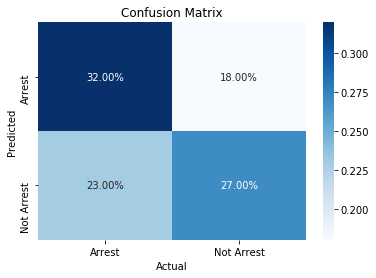

Accuracy score is :0.5851832731027362
Recall score is :0.5851832731027362


In [128]:
ibbys_cm(y_test2, adab_test_preds2)

# XGBoost DownSample

In [129]:
#Run an XGboost model

#Instantiate XGB

xgb2 = XGBClassifier()

#Fit xgb to training data
xgb2.fit(X_train2, y_train2)

# predict on training and test data

train_preds2 = xgb2.predict(X_train2)
test_preds2 = xgb2.predict(X_test2)

In [130]:
# Test the training and test data accuracy of the predictions
xgb_train_acc2 =accuracy_score(y_train2, train_preds2)
xgb_test_acc2 = accuracy_score(y_test2, test_preds2)

#Get precision and recall score
xgb_test_rec2 = recall_score(y_test2, test_preds2)
xgb_test_prec2 = precision_score(y_test2, test_preds2)
xgb_test_f1_2 = f1_score(y_test2, test_preds2)
#print both train and test accuracy
print(f'The accuracy for the training data is {xgb_train_acc2*100}%')
print(f'The accuracy for the testing data is {xgb_test_acc2*100}%')
print(f'The recall score for the testing data is {xgb_test_rec2*100}%')
print(f'The precision score for the testing data is {xgb_test_prec2*100}%')
print(f'The F1 score for the testing data is {xgb_test_f1_2*100}%')

The accuracy for the training data is 61.401652039235934%
The accuracy for the testing data is 60.35105833763552%
The recall score for the testing data is 57.55291688177594%
The precision score for the testing data is 60.964672426993324%
The F1 score for the testing data is 59.20968769917144%


In [131]:
# print(f'The cross val score is {np.mean(cross_val_score(xgb2, X2,y2, cv=3))}')

In [132]:
pdf.head()

,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,...,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,ZIP,LATITUDE,LONGITUDE,PS_LATITUDE,PS_LONGITUDE,Euc_Dist
34303,0,0,1014.0,10.0,24.0,29.0,41.860227,-87.717678,15.2,30.7,...,54.8,33.8,10402.0,96.0,60644,41.880083,-87.768200,41.880083,-87.768200,0.089677
145747,0,0,711.0,7.0,20.0,68.0,41.779975,-87.630937,3.6,29.6,...,16.5,41.0,17285.0,66.0,60636,41.779632,-87.660887,41.779632,-87.660887,0.098132
208679,0,0,823.0,8.0,13.0,65.0,41.777758,-87.721096,7.6,27.9,...,31.2,40.6,13231.0,80.0,60639,41.918609,-87.765574,41.918609,-87.765574,0.135660
259958,0,0,112.0,1.0,42.0,32.0,41.881718,-87.627760,1.3,13.8,...,7.4,21.8,59077.0,7.0,60620,41.752137,-87.644229,41.752137,-87.644229,0.004154
34263,0,0,1214.0,12.0,42.0,28.0,41.888520,-87.642820,7.4,43.1,...,27.6,42.7,12034.0,87.0,60647,41.921103,-87.697452,41.921103,-87.697452,0.016676


In [133]:
pdf['ZIP'].nunique()

19

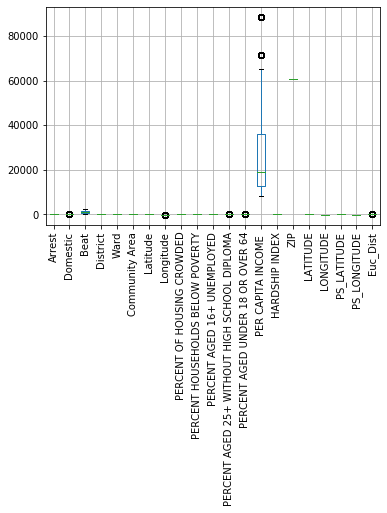

In [134]:
pdf.boxplot(rot=90)

In [135]:
pdf.columns

Index(['Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area',
       'Latitude', 'Longitude', 'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'ZIP', 'LATITUDE', 'LONGITUDE', 'PS_LATITUDE',
       'PS_LONGITUDE', 'Euc_Dist'],
      dtype='object')

In [136]:
pdf.sample(5)

,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,...,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,ZIP,LATITUDE,LONGITUDE,PS_LATITUDE,PS_LONGITUDE,Euc_Dist
247046,1,0,411.0,4.0,8.0,45.0,41.750570,-87.594252,4.7,29.8,...,26.6,41.1,16579.0,75.0,60653,41.830702,-87.623395,41.830702,-87.623395,0.132391
90410,0,1,1523.0,15.0,37.0,25.0,41.890021,-87.758915,9.4,41.7,...,24.5,43.6,10934.0,92.0,60625,41.979550,-87.692845,41.979550,-87.692845,0.129664
208610,0,0,431.0,4.0,7.0,51.0,41.714859,-87.567026,6.8,19.2,...,31.9,42.8,17104.0,64.0,60653,41.830702,-87.623395,41.830702,-87.623395,0.174895
143351,0,0,915.0,9.0,11.0,60.0,41.828425,-87.643610,11.9,29.0,...,41.5,38.9,12765.0,91.0,60623,41.856685,-87.708382,41.856685,-87.708382,0.051559
198726,1,1,431.0,4.0,7.0,51.0,41.719555,-87.568853,6.8,19.2,...,31.9,42.8,17104.0,64.0,60653,41.830702,-87.623395,41.830702,-87.623395,0.169855


In [137]:
# ROC and AUC
# confusion matrix
# Do cross fold on train and test and see whether model is over fit
# do hyper parameter tuning for better acc scores
# go back to data to and clean better and do feature engieering get rid of outliers 
# make a decision tree
# keep an untouched test set
# feature importance/analysis

In [138]:
pdf.columns

Index(['Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area',
       'Latitude', 'Longitude', 'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'ZIP', 'LATITUDE', 'LONGITUDE', 'PS_LATITUDE',
       'PS_LONGITUDE', 'Euc_Dist'],
      dtype='object')

In [139]:
pdf.drop(['LATITUDE', 'LONGITUDE','ZIP','PS_LATITUDE','PS_LONGITUDE'],axis=1,inplace=True)


In [140]:
pdf.columns

Index(['Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area',
       'Latitude', 'Longitude', 'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'Euc_Dist'],
      dtype='object')

# Get Euclidian Distance

In [141]:
pdf.head()

,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Euc_Dist
34303,0,0,1014.0,10.0,24.0,29.0,41.860227,-87.717678,15.2,30.7,15.8,54.8,33.8,10402.0,96.0,0.089677
145747,0,0,711.0,7.0,20.0,68.0,41.779975,-87.630937,3.6,29.6,23.0,16.5,41.0,17285.0,66.0,0.098132
208679,0,0,823.0,8.0,13.0,65.0,41.777758,-87.721096,7.6,27.9,17.1,31.2,40.6,13231.0,80.0,0.135660
259958,0,0,112.0,1.0,42.0,32.0,41.881718,-87.627760,1.3,13.8,4.9,7.4,21.8,59077.0,7.0,0.004154
34263,0,0,1214.0,12.0,42.0,28.0,41.888520,-87.642820,7.4,43.1,21.2,27.6,42.7,12034.0,87.0,0.016676


In [142]:
def calc_euclid(row):
    
    chi = [41.8781 , 87.6298]
    crime = [row['Latitude'], row['Longitude']]
    
    return distance.euclidean(crime,chi)

In [143]:
#pdf['Euc_Dist'] = pdf.applymap(distance.euclidean([lats,longs], [chi_loop_df['c_lat'],chi_loop_df['c_long']]),axis=1)


In [144]:
#pdf['Euc_Dist'] = pdf.apply(calc_euclid,axis=1)

In [145]:
pdf.head()

,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Euc_Dist
34303,0,0,1014.0,10.0,24.0,29.0,41.860227,-87.717678,15.2,30.7,15.8,54.8,33.8,10402.0,96.0,0.089677
145747,0,0,711.0,7.0,20.0,68.0,41.779975,-87.630937,3.6,29.6,23.0,16.5,41.0,17285.0,66.0,0.098132
208679,0,0,823.0,8.0,13.0,65.0,41.777758,-87.721096,7.6,27.9,17.1,31.2,40.6,13231.0,80.0,0.135660
259958,0,0,112.0,1.0,42.0,32.0,41.881718,-87.627760,1.3,13.8,4.9,7.4,21.8,59077.0,7.0,0.004154
34263,0,0,1214.0,12.0,42.0,28.0,41.888520,-87.642820,7.4,43.1,21.2,27.6,42.7,12034.0,87.0,0.016676


In [146]:
# drop the outliers with Z scores
# use scipy to drop outliers over 2.5,  or 3

In [147]:
from scipy import stats

In [148]:
# drop the outliers with standard scalar
# use scipy to drop outliers over 2.5,  or 3

# This is returning and array, but we want a dataframe
z_scores_pdf =  stats.zscore(pdf)

In [149]:
# Turn this array into a dataframe and make the columns the same as the pdf columns
z_scores_pdf = pd.DataFrame(z_scores_pdf, columns=pdf.columns)

In [150]:
# Filter out any zscores over an absolute value of 3
z_scores_pdf = z_scores_pdf[(np.abs(z_scores_pdf)<=3)]

In [151]:
# take the non outliers from the z_score_df and make a no outliers df using the index of the columns
no_out_pdf = pdf.iloc[z_scores_pdf.index]


In [152]:
# order the dataframe by index
no_out_pdf = no_out_pdf.sort_index(ascending=True)

# Models on No Outlier Data

In [199]:
no_out_pdf.head()

,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Euc_Dist
4,0,0,726.0,7.0,16.0,67.0,41.776722,-87.676272,3.8,46.6,28.0,28.5,42.5,11888.0,94.0,0.111522
10,1,0,724.0,7.0,6.0,68.0,41.770577,-87.649842,3.6,29.6,23.0,16.5,41.0,17285.0,66.0,0.109375
14,1,0,1532.0,15.0,37.0,25.0,41.892569,-87.745725,9.4,41.7,25.8,24.5,43.6,10934.0,92.0,0.116825
20,0,0,1814.0,18.0,43.0,7.0,41.924225,-87.639639,1.9,12.9,7.0,2.5,22.6,88669.0,1.0,0.047163
22,0,1,1235.0,12.0,25.0,31.0,41.859572,-87.650932,1.5,14.7,5.7,3.1,13.5,65526.0,3.0,0.028104


In [153]:
# Set target Variable

y3 = no_out_pdf['Arrest']

# Set features

X3 = no_out_pdf.drop('Arrest',axis=1)

# Now run a train test split

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3, test_size=.2, random_state=44)

In [154]:
# make a validation set
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train3, y_train3, test_size = .2, random_state=44)

# Random Forest

In [155]:
new_clf3 = RandomForestClassifier(criterion = 'entropy',
                            max_depth = 10,
                            n_estimators=50
                            )


# Fit the model to the training data
new_clf3.fit(X_train3, y_train3)

# use the model to predict test accuracy

y_hat_test3 = new_clf3.predict(X_test3)
rf_acc3 = accuracy_score(y_test3, y_hat_test3)
rf_prec3 = precision_score(y_test3, y_hat_test3)
rf_rec3 = recall_score(y_test3, y_hat_test3)
rf_f1_3 = f1_score(y_test3, y_hat_test3)

print(f'The accuarcy  score is {rf_acc3*100}%')
print(f'The precision score is {rf_prec3*100}%')
print(f'The recall score is {rf_rec3*100}%')
print(f'The F1 score for the testing data is {rf_f1_3*100}%')

The accuarcy  score is 62.245740836344865%
The precision score is 63.73614190687361%
The recall score is 58.717189255438676%
The F1 score for the testing data is 61.12381053638828%


# Logistic Regression No Outliers

In [156]:
# instantiate the model

logreg3 = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model to the training data

logreg3.fit(X_train3, y_train3)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [157]:
# Make predictions using this model
log_train_preds3 = logreg3.predict(X_train3)
log_test_preds3 = logreg3.predict(X_test3)

# Get training and test accuracy and other metrics
log_train_acc3 = accuracy_score(y_train3, log_train_preds3)
log_test_acc3 = accuracy_score(y_test3, log_test_preds3)
log_test_pre3 = precision_score(y_test3, log_test_preds3)
log_test_rec3 = recall_score(y_test3, log_test_preds3)
log_test_f1_3 = f1_score(y_test3, log_test_preds3)


In [158]:
#print all the metrics for the downsampled model
print(f'The accuracy for the training data is {log_train_acc3*100}%')
print(f'The accuracy for the testing data is {log_test_acc3*100}%')
print(f'The recall score for the testing data is {log_test_rec3*100}%')
print(f'The precision score for the testing data is {log_test_pre3*100}%')
print(f'The f1 score for the testing data is {log_test_f1_3*100}%')

The accuracy for the training data is 55.136809499225606%
The accuracy for the testing data is 55.86990191017037%
The recall score for the testing data is 57.430293126340516%
The precision score for the testing data is 56.21313605918225%
The f1 score for the testing data is 56.81519652419925%


In [159]:
print(f'The cross val score is {np.mean(cross_val_score(logreg3, X3,y3, cv=5))}')

The cross val score is 0.5503561080038558


# Gradient Boosting No Outliers

In [160]:
# Instantiate Gradient Boosting
gbb3 = GradientBoostingClassifier(random_state=1)

# Fit the training data 
gbb3.fit(X_train3, y_train3)

# make predictions on train and test data
gbb_train_preds3 = gbb3.predict(X_train3)
gbb_test_preds3 = gbb3.predict(X_test3)

# get training and testing accuracy
gbb_train_acc3 = accuracy_score(y_train3,gbb_train_preds3)
gbb_test_acc3 = accuracy_score(y_test3, gbb_test_preds3)




In [161]:
# Get all the other metrics 
gbb_test_rec3 = recall_score(y_test3, gbb_test_preds3)
gbb_test_pre3 = precision_score(y_test3, gbb_test_preds3)
gbb_test_f1_3 = f1_score(y_test3, gbb_test_preds3)

# Print them
print(f'The accuracy for the training data is {gbb_train_acc3*100}%')
print(f'The accuracy for the testing data is {gbb_test_acc3*100}%')
print(f'The recall score for the testing data is {gbb_test_rec3*100}%')
print(f'The precision score for the testing data is {gbb_test_pre3*100}%')
print(f'The F1 score for the testing data is {gbb_test_f1_3*100}%')

The accuracy for the training data is 61.48522199277233%
The accuracy for the testing data is 60.867320598864225%
The recall score for the testing data is 58.62526810336023%
The precision score for the testing data is 61.92685295069587%
The F1 score for the testing data is 60.2308499475341%


In [162]:
print(f'The cross val score is {np.mean(cross_val_score(gbb3, X3,y3, cv=3))}')

The cross val score is 0.6012287026041645


# AdaBoosting No Outliers

In [163]:
# Instantiate ada boost classifier
adab3 = AdaBoostClassifier(random_state=1)

# Fit ada boost to Training data
adab3.fit(X_train3,y_train3)

# get train and test predictions
adab_train_preds3 = adab3.predict(X_train3)
adab_test_preds3 = adab3.predict(X_test3)


In [164]:
# get train and test accuracy scores
adab_train_acc3 = accuracy_score(y_train3, adab_train_preds3)
adab_test_acc3 = accuracy_score(y_test3, adab_test_preds3)

# get all the other metrics for the test data
adab_test_rec3 = recall_score(y_test3, adab_test_preds3)
adab_test_pre3 = precision_score(y_test3, adab_test_preds3)
adab_test_f1_3 = f1_score(y_test3, adab_test_preds3)

#print test metrics
print(f'The accuracy for the training data is {adab_train_acc3 *100}%')
print(f'The accuracy for the testing data is {adab_test_acc3 *100}%')
print(f'The recall score for the testing data is {adab_test_rec3 *100}%')
print(f'The precision score for the testing data is {adab_test_pre3 *100}%')
print(f'The F1 score for the testing data is {adab_test_f1_3 *100}%')

The accuracy for the training data is 58.50380743417656%
The accuracy for the testing data is 58.30149716055756%
The recall score for the testing data is 58.16566234296803%
The precision score for the testing data is 58.85696568830095%
The F1 score for the testing data is 58.509272101505104%


In [165]:
#print(f'The cross val score is {np.mean(cross_val_score(adab3, X3,y3, cv=3))}')

# XGboost No Outliers

In [166]:
#Run an XGboost model

#Instantiate XGB

xgb3 = XGBClassifier()

#Fit xgb to training data
xgb3.fit(X_train3, y_train3)

# predict on training and test data

train_preds3 = xgb3.predict(X_train3)
test_preds3 = xgb3.predict(X_test3)

In [167]:
# Test the training and test data accuracy of the predictions
xgb_train_acc3 =accuracy_score(y_train3, train_preds3)
xgb_test_acc3 = accuracy_score(y_test3, test_preds3)

#Get precision and recall score
xgb_test_rec3 = recall_score(y_test3, test_preds3)
xgb_test_prec3 = precision_score(y_test3, test_preds3)
xgb_test_f1_3 = f1_score(y_test3, test_preds3)
#print both train and test accuracy
print(f'The accuracy for the training data is {xgb_train_acc3*100}%')
print(f'The accuracy for the testing data is {xgb_test_acc3*100}%')
print(f'The recall score for the testing data is {xgb_test_rec3*100}%')
print(f'The precision score for the testing data is {xgb_test_prec3*100}%')
print(f'The F1 score for the testing data is {xgb_test_f1_3 *100}%')

The accuracy for the training data is 61.15771812080537%
The accuracy for the testing data is 61.022199277232836%
The recall score for the testing data is 59.20743539985701%
The precision score for the testing data is 61.98011333262055%
The F1 score for the testing data is 60.5620559966569%


In [168]:
print(f'The cross val score is {np.mean(cross_val_score(xgb3, X3,y3, cv=3))}')

The cross val score is 0.6003923580606244


              precision    recall  f1-score   support

           0       0.60      0.63      0.61      9579
           1       0.62      0.59      0.61      9791

    accuracy                           0.61     19370
   macro avg       0.61      0.61      0.61     19370
weighted avg       0.61      0.61      0.61     19370

Accurancy:  0.6102219927723284


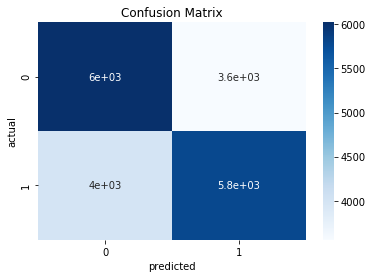

In [169]:
evaluation(y_test3,test_preds3)

# Tuning Hyperparameters

#### Use 3 best models

In [170]:
# Random Forest, XGBoost, Gradient Boosting

# Random Forest Tuning

In [204]:
# fit the gridsearch object to the training data
rft_grid.fit(X_train3,y_train3)


//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [205]:
# get the acc score for the grid
rft_grid.score(X_test3, y_test3)


0.6356737222509035

              precision    recall  f1-score   support

           0       0.62      0.66      0.64      9579
           1       0.65      0.61      0.63      9791

    accuracy                           0.63     19370
   macro avg       0.63      0.63      0.63     19370
weighted avg       0.63      0.63      0.63     19370

Accurancy:  0.6341765616933402


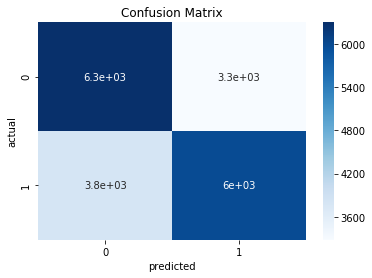

In [174]:
# get predictions 
rft_predictions = rft_grid.predict(X_test3)

#plot confusion matrix

evaluation(y_test3,rft_predictions)

# XGBoostClassifier Tuning

In [175]:
%%time 
# Instantiate XGB Classifier
xgbt = XGBClassifier(learning_rate=.3,
                    n_estimators=200,
                    max_depth=15,
                    gamma=1)

# Fit the model
xgbt.fit(X_train3, y_train3)



CPU times: user 43.5 s, sys: 44.8 ms, total: 43.6 s
Wall time: 43 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.3, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [176]:
6000/9800

0.6122448979591837

In [177]:
xgbt.score(X_test3,y_test3)

0.63309241094476

In [178]:
# get the important features
xgbt_feat_imp = xgbt.feature_importances_

In [179]:
# Turn this array into a dataframe and make the columns the same as the pdf columns
xgbt_feat_imp = pd.DataFrame(xgbt_feat_imp, index=X3.columns)
# Change the column from 0 to another name (feature_score)
xgbt_feat_imp.rename({0:'feature_score'},axis=1,inplace=True)
#sort the dataframe by feature score
xgbt_feat_imp = xgbt_feat_imp.sort_values(by=['feature_score'], ascending=False)
#See the data frame
xgbt_feat_imp.drop('District',axis=0, inplace=True)

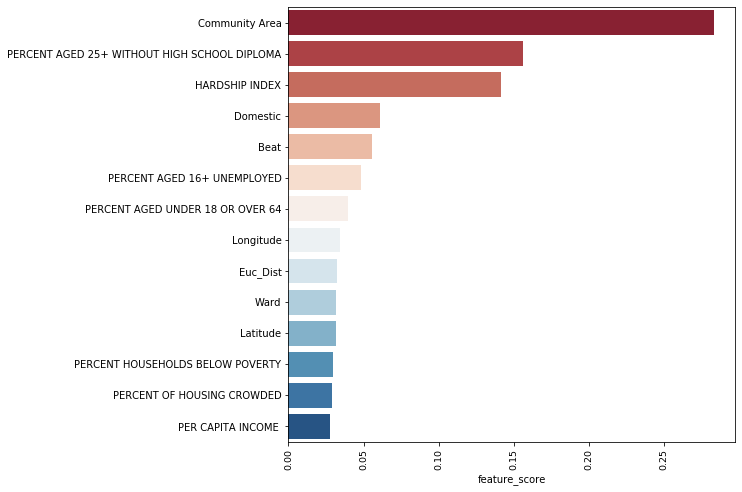

In [180]:
plt.figure(figsize=[8,8])
sns.barplot(y = xgbt_feat_imp.index, x = xgbt_feat_imp['feature_score'], palette='RdBu', orient='h');
plt.xticks(rotation='vertical', fontsize=9.5);
#plt.title('Feature Importance');


In [181]:
xgbt_preds = xgbt.predict(X_test3)

              precision    recall  f1-score   support

           0       0.63      0.64      0.63      9579
           1       0.64      0.63      0.63      9791

    accuracy                           0.63     19370
   macro avg       0.63      0.63      0.63     19370
weighted avg       0.63      0.63      0.63     19370

Accurancy:  0.63309241094476


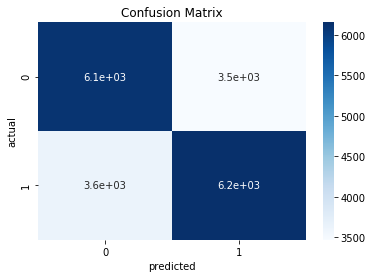

In [182]:
evaluation(y_test3, xgbt_preds)


# AdaBoost Tuning

In [198]:
%%time
adat = AdaBoostClassifier(random_state=1,
                          base_estimator= DecisionTreeClassifier(max_depth=5),
                          n_estimators = 250,
                          learning_rate = .4,
                         )


#fit the model

adat.fit(X_train3, y_train3)


TypeError: __init__() got an unexpected keyword argument 'n_jobs'

In [184]:
adat.score(X_test3, y_test3)

0.6206504904491482

In [185]:
# make predictions using the adat
adat_predictions = adat.predict(X_test3)

              precision    recall  f1-score   support

           0       0.62      0.62      0.62      9579
           1       0.62      0.62      0.62      9791

    accuracy                           0.62     19370
   macro avg       0.62      0.62      0.62     19370
weighted avg       0.62      0.62      0.62     19370

Accurancy:  0.6206504904491482


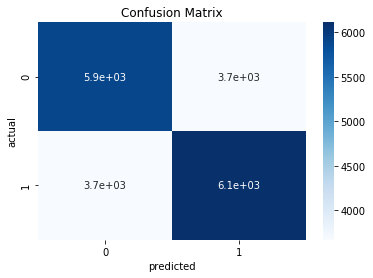

In [186]:
#make a confusion matrix
evaluation(y_test3, adat_predictions)

# Mapping the Distances

In [187]:
import os
import folium
from folium.plugins import HeatMap

In [188]:
pdf.head()

,Arrest,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Euc_Dist
34303,0,0,1014.0,10.0,24.0,29.0,41.860227,-87.717678,15.2,30.7,15.8,54.8,33.8,10402.0,96.0,0.089677
145747,0,0,711.0,7.0,20.0,68.0,41.779975,-87.630937,3.6,29.6,23.0,16.5,41.0,17285.0,66.0,0.098132
208679,0,0,823.0,8.0,13.0,65.0,41.777758,-87.721096,7.6,27.9,17.1,31.2,40.6,13231.0,80.0,0.135660
259958,0,0,112.0,1.0,42.0,32.0,41.881718,-87.627760,1.3,13.8,4.9,7.4,21.8,59077.0,7.0,0.004154
34263,0,0,1214.0,12.0,42.0,28.0,41.888520,-87.642820,7.4,43.1,21.2,27.6,42.7,12034.0,87.0,0.016676


In [200]:
df.head()

,Date,Block,IUCR,Primary Type,Arrest,Domestic,Beat,District,Ward,Community Area,...,Longitude,Location,COMMUNITY AREA NAME,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Euc_Dist
0,01/15/2016 02:05:00 PM,043XX N CENTRAL PARK AVE,0320,ROBBERY,0,0,1723.0,17.0,35.0,16,...,-87.718000,"(41.959835996, -87.717999724)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.120250
2275,02/03/2016 07:00:00 PM,043XX N ELSTON AVE,0560,ASSAULT,0,0,1722.0,17.0,39.0,16,...,-87.728585,"(41.960161177, -87.728585458)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.128424
2286,02/11/2016 12:10:00 AM,037XX N KIMBALL AVE,0560,ASSAULT,1,0,1732.0,17.0,35.0,16,...,-87.712781,"(41.94896278, -87.712781393)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.109121
2301,02/25/2016 10:00:00 AM,037XX N ELSTON AVE,0560,ASSAULT,0,0,1733.0,17.0,35.0,16,...,-87.712274,"(41.948973757, -87.712273992)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.108743
2546,08/16/2016 05:30:00 PM,042XX W ROSCOE ST,0460,BATTERY,0,0,1731.0,17.0,30.0,16,...,-87.733798,"(41.942647489, -87.733797696)",Dunning,10.6,10.0,16.2,33.6,26282,28.0,0.122401


In [189]:
arrest_coords = pdf.groupby(['Latitude', 'Longitude']).agg({'Euc_Dist':'count'}).reset_index()
arrest_coords.head()

,Latitude,Longitude,Euc_Dist
0,41.644818,-87.614692,1
1,41.645796,-87.542472,1
2,41.645970,-87.542700,1
3,41.646296,-87.616662,1
4,41.647038,-87.614224,1


In [190]:
arrest_coords_mlist = [(x[0],x[1],x[2]) for x in arrest_coords.values]

In [191]:
chicago_heat_map = folium.Map([41.8819,-87.6276], zoom_start = 10)
HeatMap(arrest_coords, radius = 10).add_to(chicago_heat_map)


chicago_heat_map

# Feature Analysis
##### use feature_importance function

# Confusion Matrix

In [192]:
# Cross validate the model
np.mean(cross_val_score(new_clf3, X3,y3, cv=3))

0.610211672987692

In [193]:
## 
# label the axis
labels = ['Arrest', 'Not Arrest']


In [194]:
# Joels confusion matrix function
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in predicted and true values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    
    import seaborn as sns
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat, average = 'weighted')
    recall = recall_score(y, y_hat, average = 'weighted')
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat))
    print('Accurancy: ', accuracy)
    sns.heatmap(cm,  cmap= 'Blues', annot=True)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

              precision    recall  f1-score   support

           0       0.90      0.27      0.41     42340
           1       0.23      0.88      0.37     10484

    accuracy                           0.39     52824
   macro avg       0.57      0.58      0.39     52824
weighted avg       0.77      0.39      0.40     52824

Accurancy:  0.3908829320006058


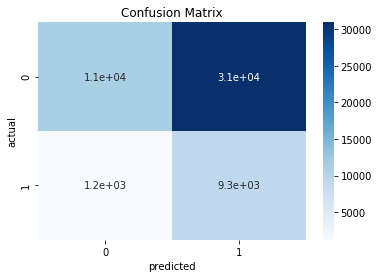

In [195]:
evaluation(y_test, y_hat_test1)

In [196]:
# # Newer updated Conf Matrix Function
# def ibbys_cm(y, y_hat, title='Confusion Matrix'):
#     cm = np.round(confusion_matrix(y_val3, y_hat_test3)/len(y_val3), 2)
#     cm = sns.heatmap(cm, annot = True, cmap='Blues', fmt=".2%");
#     plt.xlabel('Predicted');
#     plt.ylabel('True');
#     cm.set_xticklabels(labels);
#     cm.set_yticklabels(labels);
#     plt.title('Confusion Matrix');
#     plt.show()

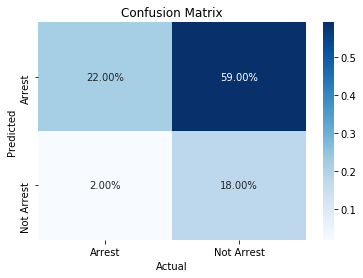

Accuracy score is :0.3908829320006058
Recall score is :0.3908829320006058


In [197]:
ibbys_cm(y_test, y_hat_test1)